# Analysing Results

In [28]:
import gzip

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

from lcdb.analysis import read_csv_results
from lcdb.analysis.plot import plot_learning_curves


update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [29]:
source_csv = "output/lcdb.workflow.sklearn.RandomForestWorkflow/3/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:bootstrap,p:criterion,p:max_features,p:max_samples,p:min_impurity_decrease,p:min_samples_leaf,p:min_samples_split,p:n_estimators,p:pp@cat_encoder,p:pp@decomposition,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
90,True,gini,sqrt,1.000000,0.000000,2,2,100,ordinal,none,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
0,True,gini,all,0.688607,0.991518,24,17,11,onehot,none,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
69,False,entropy,log2,0.926895,0.631193,2,3,33,ordinal,kernel_pca,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
74,False,gini,all,0.512597,0.685582,17,9,62,onehot,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
45,True,entropy,all,0.287223,0.363889,2,46,12,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,True,entropy,all,0.589306,0.851681,18,18,18,onehot,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
823,False,log_loss,log2,0.189655,0.268705,13,6,18,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
828,False,gini,log2,0.638540,0.684096,15,26,20,ordinal,ka_rbf,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
824,False,entropy,log2,0.851528,0.704902,9,33,37,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [30]:
r_df_failed

,p:bootstrap,p:criterion,p:max_features,p:max_samples,p:min_impurity_decrease,p:min_samples_leaf,p:min_samples_split,p:n_estimators,p:pp@cat_encoder,p:pp@decomposition,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
42,False,entropy,log2,0.513934,0.662445,18,7,29,onehot,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
50,False,gini,log2,0.240286,0.858893,2,20,94,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
79,False,log_loss,all,0.817880,0.875567,1,44,21,onehot,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
81,False,log_loss,log2,0.969483,0.158707,21,8,39,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
92,True,log_loss,all,0.781003,0.532829,14,40,456,onehot,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
95,False,gini,log2,0.029698,0.904178,19,27,351,onehot,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
110,True,gini,log2,0.872038,0.217734,15,18,62,ordinal,fastica,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
123,False,log_loss,log2,0.297300,0.575466,3,10,343,ordinal,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
127,False,entropy,sqrt,0.239825,0.429879,14,13,189,onehot,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
137,False,gini,all,0.051424,0.289179,8,27,127,ordinal,agglomerator,...,3,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [31]:
timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Experiment duration: 315.08119535446167 seconds


In [32]:
# Display the error of a failed job
idx = 0
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 208, in fit_workflow_on_current_anchor
    self.workflow.fit(
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 67, in terminate_on_timeout
    return results.get(timeout)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 774, in get
    raise self._value
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/workflow/_base_workflow.py", line 31, in fit
    self._fit(X=X, y=y, metadata=metadata, *args, **kwargs)
  File "/lus/grand/projects/datascience/regele/po

In [33]:
# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues, QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryEpochValues, QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix

In [34]:
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
accuracy_values = out.apply(lambda x: list(map(accuracy_from_confusion_matrix, x))).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, accuracy_values)):
    anchor_values[i] = xi[:len(yi)]

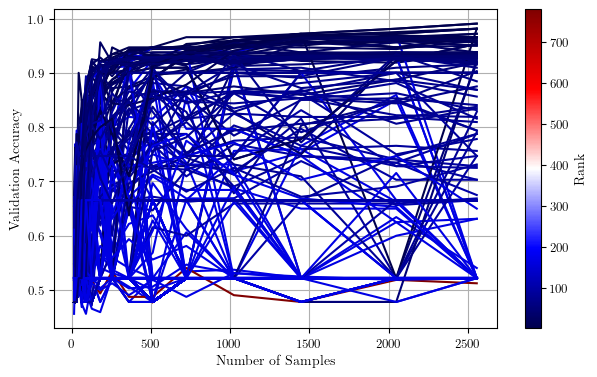

In [35]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Accuracy")
plt.show()

In [39]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
accuracy_values = out.apply(
    lambda x: list(map(accuracy_from_confusion_matrix, x))
).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, accuracy_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, accuracy_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

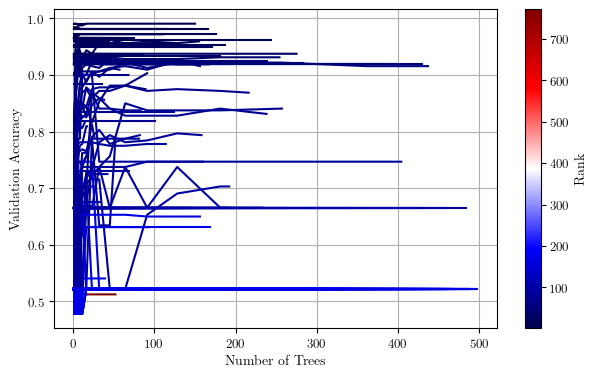

In [41]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Trees")
ax.set_ylabel(f"Validation Accuracy")
plt.show()